In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [2]:
import torch
use_device = "cuda:0"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: NVIDIA GeForce RTX 2080

torch: 2.6.0+cu126
cuda:  12.6
cudnn: 90501
dtype: torch.float32


# File locations

In [3]:
input_dir = root_dir + "output/multisubject/"
joined_model_dir = input_dir + 'gnet8j_mpf_evc_1_all_May-04-2025_2344/' 
roiwise_model_dir = input_dir + 'gnet8r_mpf_evc_1_all_May-03-2025_1605/'# 'gnet8r_mpf_evc_Feb-04-2022_1844/'
output_dir = input_dir

# Reload joined GNet model files

In [5]:
joined_checkpoint = torch.load(joined_model_dir + 'model_params_1_all_epoch20', map_location=use_device, weights_only=False)
print (joined_checkpoint.keys())

dict_keys(['num_epochs', 'batch_size', 'holdout_frac', 'best_params', 'final_params', 'trn_loss_history', 'hold_loss_history', 'hold_cc_history', 'best_epoch', 'best_joint_cc_score', 'val_cc', 'input_mean', 'brain_nii_shape', 'voxel_index', 'voxel_roi', 'voxel_mask'])


## Voxel masks

In [6]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

roi_group_names = ['V1', 'V2', 'V3', 'hV4']
roi_group = [[1,2],[3,4],[5,6], [7]]

In [7]:
subjects = list(joined_checkpoint['voxel_mask'].keys())
gnet8j_voxel_mask = joined_checkpoint['voxel_mask']
gnet8j_voxel_roi  = joined_checkpoint['voxel_roi']
gnet8j_voxel_index= joined_checkpoint['voxel_index']
gnet8j_brain_nii_shape= joined_checkpoint['brain_nii_shape']
gnet8j_val_cc = joined_checkpoint['val_cc']

# Reload ROI-wise models

In [8]:
roiwise_model_dirs = {
    'V1': '%smodel_params_V1_1_all_epoch20' % roiwise_model_dir,
    'V2': '%smodel_params_V2_1_all_epoch20' % roiwise_model_dir,
    'V3': '%smodel_params_V3_1_all_epoch20' % roiwise_model_dir,
    'hV4': '%smodel_params_hV4_1_all_epoch20' % roiwise_model_dir
    }

roiwise_checkpoint = {}
for r,t in roiwise_model_dirs.items():
    roiwise_checkpoint[r] = torch.load(t, map_location=use_device,weights_only=False)

In [9]:
cp = roiwise_checkpoint[list(roiwise_model_dirs.keys())[0]]
subjects = list(cp['voxel_mask'].keys())
gnet8r_voxel_mask = cp['voxel_mask']
gnet8r_voxel_roi  = cp['voxel_roi']
gnet8r_voxel_index= cp['voxel_index']
gnet8r_brain_nii_shape= cp['brain_nii_shape']
#these masks should be the same for all model components

In [10]:
gnet8r_val_cc = {s: np.zeros_like(v).astype(np.float32) for s,v in gnet8r_voxel_roi.items()}

for k,(roi_name, cp) in enumerate(roiwise_checkpoint.items()):
    for s in gnet8r_voxel_roi.keys():
        group_mask = cp['group_mask'][s][:len(gnet8r_val_cc[s])]
        gnet8r_val_cc[s][group_mask] = cp['val_cc'][s][:len(gnet8r_val_cc[s])]

---
# Layerwise tuning masks

In [45]:
n_fmaps=[np.sum(layerwise_tuning_mask) for layerwise_tuning_mask in layerwise_tuning_masks]

In [22]:
NN = 128
layerwise_tuning_masks = [np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool)]
layerwise_tuning_masks[0][0:int(NN)] = True
layerwise_tuning_masks[1][int(NN):int(3*NN/2)] = True
layerwise_tuning_masks[2][int(3*NN/2):int(2*NN)] = True
layerwise_tuning_masks[3][int(2*NN):int(5*NN/2)] = True
layerwise_tuning_masks[4][int(5*NN/2):int(3*NN)] = True
layerwise_tuning_masks[5][int(3*NN):int(7*NN/2)] = True
layerwise_tuning_masks[6][int(7*NN/2):] = True

layer_cmap = [plt.get_cmap('magma', len(layerwise_tuning_masks)+1)(k) for k in range(len(layerwise_tuning_masks)+1)]

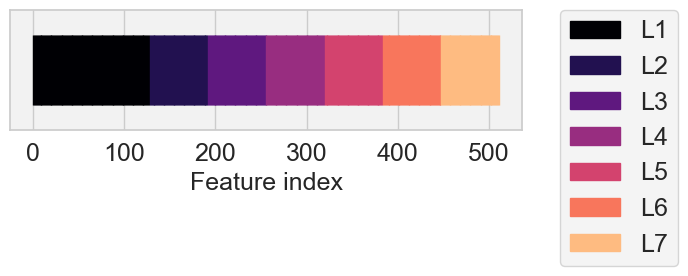

In [23]:
from PIL import Image
from matplotlib.patches import Patch

fig=plt.figure(figsize=(8, 2))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=layer_cmap[k], edgecolor=layer_cmap[k], label='L%d'%(k+1)) for k,tm in enumerate(layerwise_tuning_masks)]
for k,tm in enumerate(layerwise_tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=layer_cmap[k], ms=50)
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [24]:
filename = output_dir + "gnet8x_feature_layer_distribution.png"  
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Bipartite tuning masks

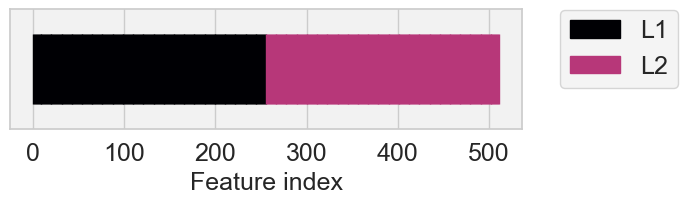

In [25]:
NN = 128
bipartite_tuning_masks = [np.zeros(shape=(int(4*NN))).astype(bool),
                          np.zeros(shape=(int(4*NN))).astype(bool)]
bipartite_tuning_masks[0][0:int(2*NN)] = True
bipartite_tuning_masks[1][int(2*NN):] = True

bipartite_cmap = [plt.get_cmap('magma', len(bipartite_tuning_masks)+1)(k) for k in range(len(bipartite_tuning_masks)+1)]

from PIL import Image
from matplotlib.patches import Patch

fig=plt.figure(figsize=(8, 2))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=bipartite_cmap[k], edgecolor=bipartite_cmap[k], label='L%d'%(k+1)) for k,tm in enumerate(bipartite_tuning_masks)]
for k,tm in enumerate(bipartite_tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=bipartite_cmap[k], ms=50)
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [26]:
filename = output_dir + "gnet8x_feature_bipartite_distribution.png"  
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

In [27]:
from src.tuning3 import tuning_and_spread

# Comparision

(0.0, 1.0)

<Figure size 800x800 with 0 Axes>

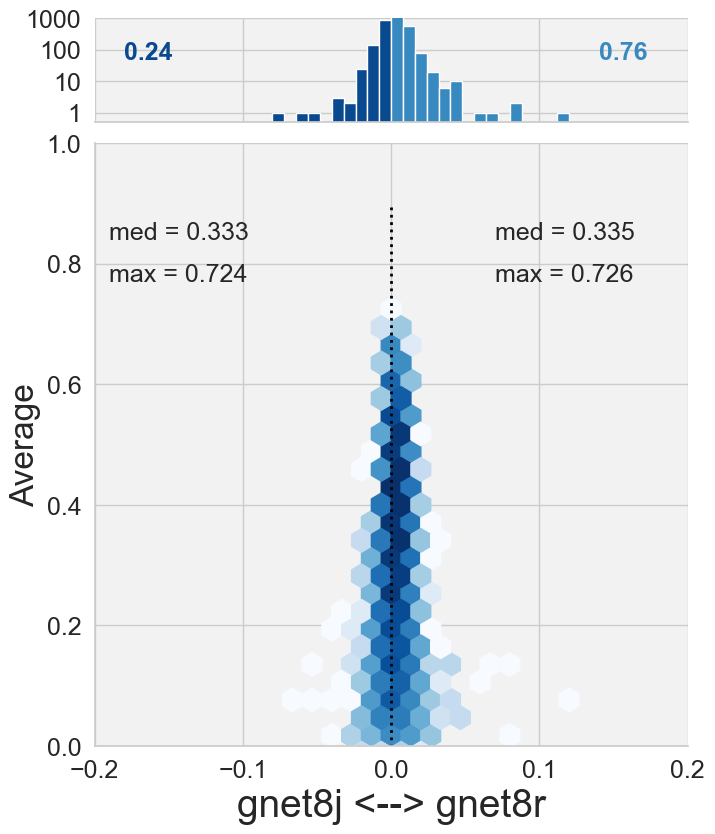

In [28]:
from src.plots import plot_fwrf_paper_compare

x = np.concatenate([v for s,v in gnet8r_val_cc.items()])
y = np.concatenate([v for s,v in gnet8j_val_cc.items()])

fig=plt.figure(figsize=(8, 8))
fig=plot_fwrf_paper_compare(x, y, 0.055, [-.2, .2], [-.1, .9])
ax=fig.ax_joint
ax.text(x=-.2+.01, y=.84, s='med = %.3f'%np.median(np.nan_to_num(y)), fontsize=18)
ax.text(x=-.2+.01, y=.77, s='max = %.3f'%np.max(np.nan_to_num(y)), fontsize=18)
ax.text(x=.2 - .13, y=.84, s='med = %.3f'%np.median(np.nan_to_num(x)), fontsize=18)
ax.text(x=.2 - .13, y=.77, s='max = %.3f'%np.max(np.nan_to_num(x)), fontsize=18)
plt.xlabel('gnet8j <--> gnet8r',fontsize=28)
plt.ylabel('Average',fontsize=24)
plt.ylim(0,1)

In [30]:
filename = output_dir + 'gnet8j_v_gnet8r.png' 
fig.savefig(filename, **savearg)
plt.close()

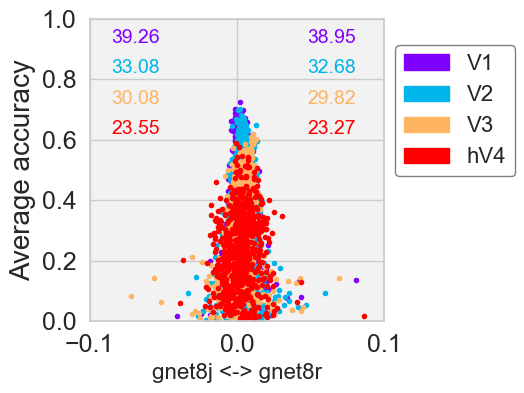

In [31]:
fig=plt.figure(figsize=(20,8))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.85, top=.95, wspace=0.25, hspace=0.25)
axes = [plt.subplot(2, 4, k+1) for k in range(len(subjects))]
for k,s in enumerate(subjects):
    
    X = gnet8r_val_cc[s] 
    Y = gnet8j_val_cc[s]
    
    # gnet8j - anet,  X - Z
    plt.sca(axes[k])
    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8j_voxel_roi[s], roi_map)):                
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((Y + X)/2)[mask], linestyle='None', marker='.', color=roi_cmap[i])
        plt.text(-.085, 0.92-i*0.1, '%.02f'%(np.sum(X[mask])*100/len(X[mask])), fontsize=14, color=roi_cmap[i])  
        plt.text(.048, 0.92-i*0.1, '%.02f'%(np.sum(Y[mask])*100/len(Y[mask])), fontsize=14, color=roi_cmap[i])  
        
    #plt.text(-.045, .75, '%.01f'%(np.sum(Y-X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    #plt.text(.025, .75, '%.01f'%(np.sum(X-Y>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
     
#plt.sca(axes[3])        
legend_elements = [Patch(facecolor=roi_cmap[i], edgecolor=roi_cmap[i], \
    label=roi_name) for i,roi_name in enumerate(roi_group_names)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')
plt.xlim([-.05,.05])
plt.ylim([0,1.0])

plt.ylabel('Average accuracy',fontsize=20)
plt.xlabel('gnet8j <-> gnet8r',fontsize=16)
ax = plt.gca()
ax.set_xticks([-.1, 0, .1])

In [33]:
filename = output_dir + "gnet8r_v_gnet8j_2.png"  
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

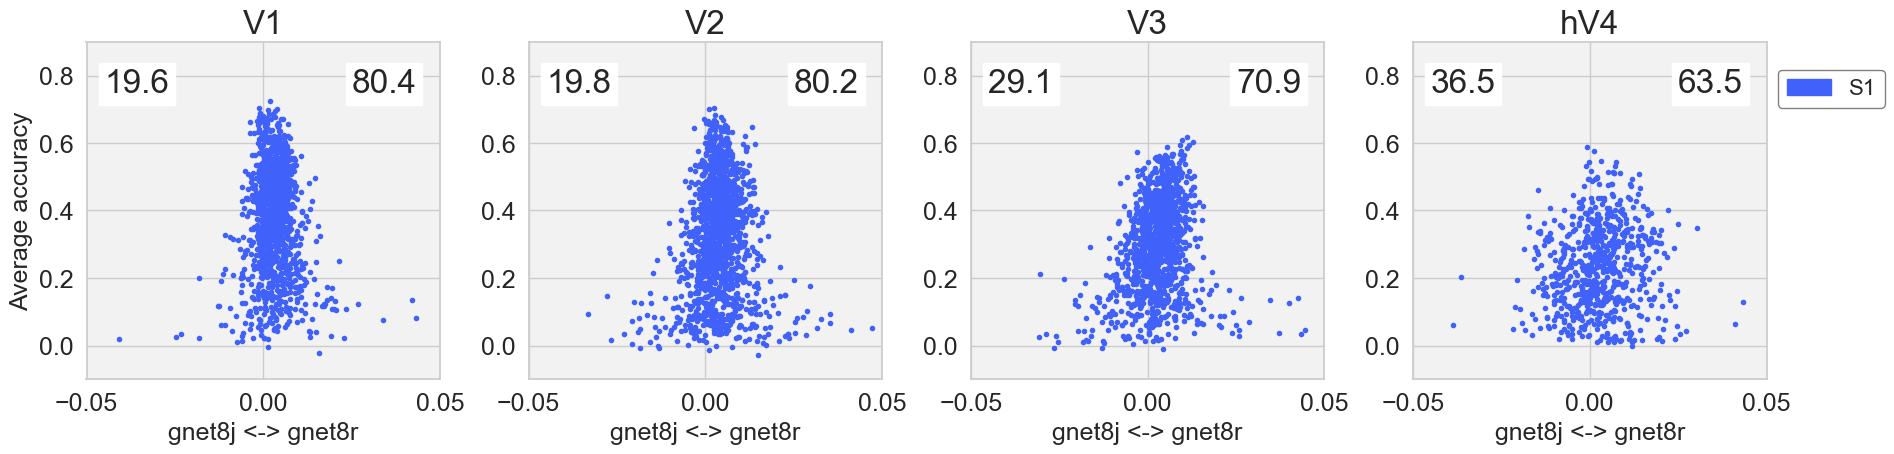

In [34]:
fig=plt.figure(figsize=(24,4.5))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.9, wspace=0.25, hspace=0.25)
XY_roi_compare = {roi: [] for roi in roi_group_names}
axes = [plt.subplot(1, 4, k+1) for k in range(len(roi_group_names))]

for k,s in enumerate(subjects):
    
    X = gnet8r_val_cc[s] 
    Y = gnet8j_val_cc[s]

    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8j_voxel_roi[s], roi_map, roi_group_names)):                
        plt.sca(axes[i])
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((X+Y)/2)[mask], linestyle='None', marker='.', color=subj_cmap[s])
    
        XY_roi_compare[roi_name] += [(X - Y)[mask],]

        plt.xlim([-.05,.05])
        plt.ylim([-.1,.9])
        plt.title(roi_name)
        ax = plt.gca()
        ax.set_xticks([-.05, 0, .05])
    
    for i,roi_name in enumerate(roi_group_names):
        
        plt.sca(axes[i])
        X = np.concatenate(XY_roi_compare[roi_name])
        plt.text(-.045, .75, '%.01f'%(np.sum(X<0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
        plt.text(.025, .75, '%.01f'%(np.sum(X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
        if i==0:
            plt.ylabel('Average accuracy')
            
        plt.xlabel('gnet8j <-> gnet8r')
                
plt.sca(axes[-1])          
legend_elements = [Patch(facecolor=subj_cmap[s], edgecolor=subj_cmap[s], label='S%d'%s) for s in subjects]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')

In [35]:
filename = output_dir + "gnet8r_v_gnet8j.png"  
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

## Reload gnet8r layerwise

In [36]:
data_set = h5py.File(roiwise_model_dir + "gnet8r_layerwise_tuning_var.h5py", 'r')
subject_total_val_cc          = {int(s): np.copy(d) for s,d in embed_dict(data_set)['val_cc'].items()}
subject_partition_incl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['incl_val_cc'].items()}
subject_partition_excl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['excl_val_cc'].items()}
data_set.close()
subject_incl_tunings, subject_incl_tunings_err, subject_incl_tuning_argmax, subject_incl_tuning_spread, \
subject_excl_tunings, subject_excl_tunings_err, subject_excl_tuning_argmax, subject_excl_tuning_spread = \
    tuning_and_spread(subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc)

100%|███████████████████████████████████████████████████████████████████████████| 4657/4657 [00:00<00:00, 36416.04it/s]


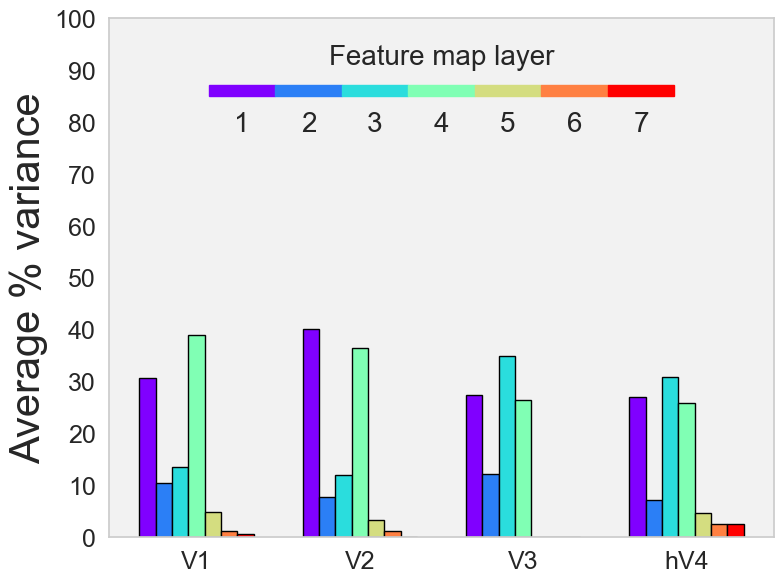

In [54]:
cmap = [plt.get_cmap('rainbow', subject_excl_tunings[s].shape[0])(k) for k in range(7)]

fig,ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    roi_average_y_all=[]
    roi_average_z_all=[]
    for i in range(subject_excl_tunings[s].shape[0]):
        Y, Z, dY, dZ, Ycc = [], [], [], [], []
        for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
            val_cc = subject_total_val_cc[s][:,0] # (mean, std)
            mask = np.logical_and(roi_mask[:len(val_cc)], val_cc>.055)

            Y  += [ subject_excl_tunings[s][i,mask], ] #Y unique
            Z  += [ subject_incl_tunings[s][i,mask], ] #Z specific
            dY  += [ subject_excl_tunings_err[s][i,mask], ]
            dZ  += [ subject_incl_tunings_err[s][i,mask], ]
            Ycc+= [ val_cc[mask], ]

        roi_average_y = [np.average(y, weights=np.square(ycc), axis=0)/n_fmaps[i] for y,ycc in zip(Y, Ycc)]
        roi_average_z = [np.average(z, weights=np.square(ycc), axis=0)/n_fmaps[i] for z,ycc in zip(Z, Ycc)]
        roi_average_dy = [np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)]
        roi_average_dz = [np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)]
        roi_average_y_all.append(roi_average_y)
        roi_average_z_all.append(roi_average_z)
        
    for i in range(subject_excl_tunings[s].shape[0]):
        roi_average_y_sum=np.sum(roi_average_y_all,axis=0)
        roi_average_z_sum=np.sum(roi_average_z_all,axis=0)
        _=plt.bar(x=np.arange(len(Y))+0.1*i, height=roi_average_y_all[i]/roi_average_y_sum*100, width=0.1, color=cmap[i], edgecolor='k',alpha=1.0,label=f'layer {i}')
        #_=plt.bar(x=1.1*np.arange(len(Y))+0.1*i, height=roi_average_z_all[i]/roi_average_z_sum*100, width=0.1, color=cmap[i], edgecolor='k')
        
        values_y += [roi_average_y,]
        values_z += [roi_average_z,]
        values_dy += [roi_average_dy,]
        values_dz += [roi_average_dz,]    

plt.gca().set_xticks(np.arange(len(roi_group))*1.0+0.3)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance',fontsize=30)
plt.grid(False)
ax.set_yticks(np.arange(0,110,10))

import matplotlib.patches as mpatches
start_x = 0.1
width = 0.1
height = 0.02
y_pos = 0.85  # How far below the plot (adjust as needed)
labels = ['1', '2', '3', '4', '5', '6', '7']
ax.text(1.8,95,'Feature map layer', ha='center', va='top',fontsize=20)
for i, (color, label) in enumerate(zip(cmap, labels)):
    rect = mpatches.Rectangle((start_x + i*width + width/2, y_pos), width, height, color=color, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(start_x + i*width + width, y_pos - 0.03, label, transform=ax.transAxes, ha='center', va='top', fontsize=20)
    
plt.ylim(0,100)
plt.tight_layout()

In [55]:
filename = output_dir + 'gnet8r_layerwise_unique_y.png'  
fig.savefig(filename, **savearg)
plt.close()

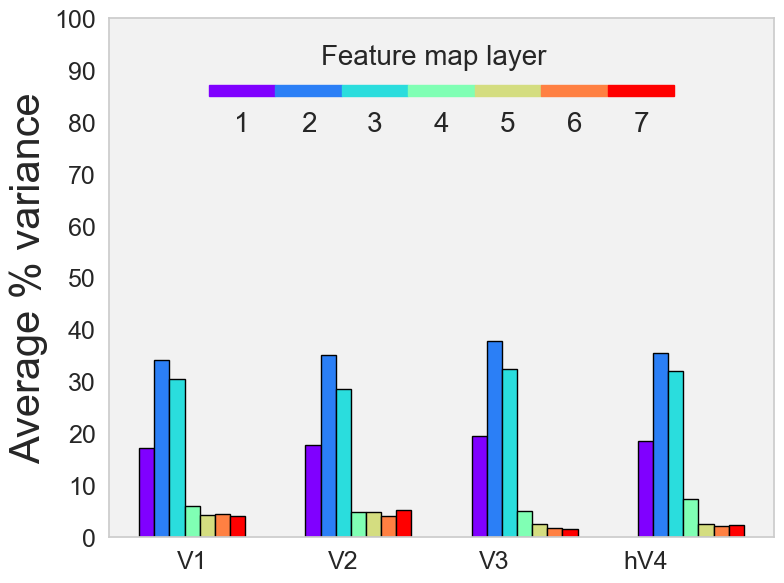

In [59]:
cmap = [plt.get_cmap('rainbow', subject_excl_tunings[s].shape[0])(k) for k in range(7)]

fig,ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    roi_average_y_all=[]
    roi_average_z_all=[]
    for i in range(subject_excl_tunings[s].shape[0]):
        Y, Z, dY, dZ, Ycc = [], [], [], [], []
        for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
            val_cc = subject_total_val_cc[s][:,0] # (mean, std)
            mask = np.logical_and(roi_mask[:len(val_cc)], val_cc>.055)

            Y  += [ subject_excl_tunings[s][i,mask], ] #Y unique
            Z  += [ subject_incl_tunings[s][i,mask], ] #Z specific
            dY  += [ subject_excl_tunings_err[s][i,mask], ]
            dZ  += [ subject_incl_tunings_err[s][i,mask], ]
            Ycc+= [ val_cc[mask], ]

        roi_average_y = [np.average(y, weights=np.square(ycc), axis=0)/n_fmaps[i] for y,ycc in zip(Y, Ycc)]
        roi_average_z = [np.average(z, weights=np.square(ycc), axis=0)/n_fmaps[i] for z,ycc in zip(Z, Ycc)]
        roi_average_dy = [np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)]
        roi_average_dz = [np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)]
        roi_average_y_all.append(roi_average_y)
        roi_average_z_all.append(roi_average_z)
        
    for i in range(subject_excl_tunings[s].shape[0]):
        roi_average_y_sum=np.sum(roi_average_y_all,axis=0)
        roi_average_z_sum=np.sum(roi_average_z_all,axis=0)
        #_=plt.bar(x=1.0*np.arange(len(Y))+0.1*i, height=roi_average_y_all[i]/roi_average_y_sum*100, width=0.1, color=cmap[i], edgecolor='k',alpha=1.0,label=f'layer {i}')
        _=plt.bar(x=1.1*np.arange(len(Y))+0.1*i, height=roi_average_z_all[i]/roi_average_z_sum*100, width=0.1, color=cmap[i], edgecolor='k')
        
        values_y += [roi_average_y,]
        values_z += [roi_average_z,]
        values_dy += [roi_average_dy,]
        values_dz += [roi_average_dz,]    

plt.gca().set_xticks(np.arange(len(roi_group))*1.0+0.3)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance',fontsize=30)
plt.grid(False)
ax.set_yticks(np.arange(0,110,10))

import matplotlib.patches as mpatches
start_x = 0.1
width = 0.1
height = 0.02
y_pos = 0.85  # How far below the plot (adjust as needed)
labels = ['1', '2', '3', '4', '5', '6', '7']
ax.text(1.9,95,'Feature map layer', ha='center', va='top',fontsize=20)
for i, (color, label) in enumerate(zip(cmap, labels)):
    rect = mpatches.Rectangle((start_x + i*width + width/2, y_pos), width, height, color=color, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(start_x + i*width + width, y_pos - 0.03, label, transform=ax.transAxes, ha='center', va='top', fontsize=20)
    
plt.ylim(0,100)
plt.tight_layout()

In [60]:
filename = output_dir + 'gnet8r_layerwise_specific_z.png'  
fig.savefig(filename, **savearg)
plt.close()

## Reload gnet8j layerwise

In [61]:
data_set = h5py.File(joined_model_dir + "gnet8j_layerwise_tuning_var.h5py", 'r')
subject_total_val_cc          = {int(s): np.copy(d) for s,d in embed_dict(data_set)['val_cc'].items()}
subject_partition_incl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['incl_val_cc'].items()}
subject_partition_excl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['excl_val_cc'].items()}
data_set.close()
subject_incl_tunings, subject_incl_tunings_err, subject_incl_tuning_argmax, subject_incl_tuning_spread, \
subject_excl_tunings, subject_excl_tunings_err, subject_excl_tuning_argmax, subject_excl_tuning_spread = \
    tuning_and_spread(subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc)

100%|███████████████████████████████████████████████████████████████████████████| 4657/4657 [00:00<00:00, 36604.12it/s]


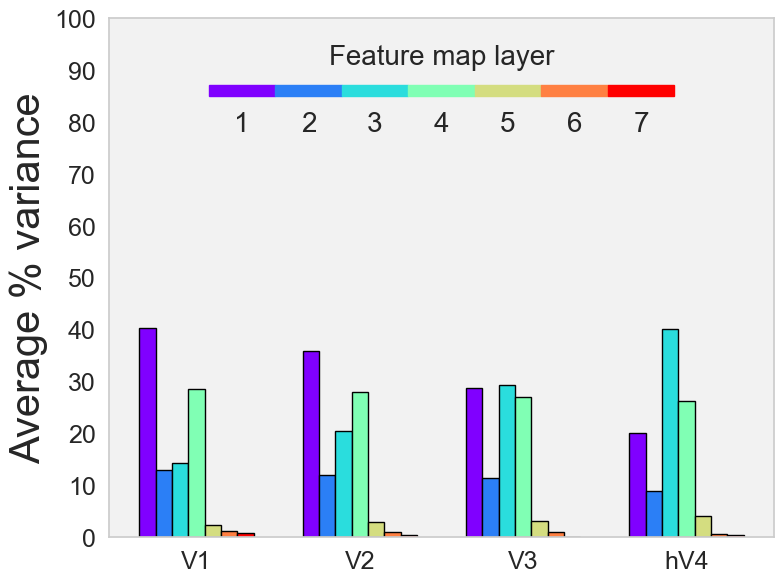

In [65]:
cmap = [plt.get_cmap('rainbow', subject_excl_tunings[s].shape[0])(k) for k in range(7)]

fig,ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    roi_average_y_all=[]
    roi_average_z_all=[]
    for i in range(subject_excl_tunings[s].shape[0]):
        Y, Z, dY, dZ, Ycc = [], [], [], [], []
        for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
            val_cc = subject_total_val_cc[s][:,0] # (mean, std)
            mask = np.logical_and(roi_mask[:len(val_cc)], val_cc>.055)

            Y  += [ subject_excl_tunings[s][i,mask], ] #Y unique
            Z  += [ subject_incl_tunings[s][i,mask], ] #Z specific
            dY  += [ subject_excl_tunings_err[s][i,mask], ]
            dZ  += [ subject_incl_tunings_err[s][i,mask], ]
            Ycc+= [ val_cc[mask], ]

        roi_average_y = [np.average(y, weights=np.square(ycc), axis=0)/n_fmaps[i] for y,ycc in zip(Y, Ycc)]
        roi_average_z = [np.average(z, weights=np.square(ycc), axis=0)/n_fmaps[i] for z,ycc in zip(Z, Ycc)]
        roi_average_dy = [np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)]
        roi_average_dz = [np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)]
        roi_average_y_all.append(roi_average_y)
        roi_average_z_all.append(roi_average_z)
        
    for i in range(subject_excl_tunings[s].shape[0]):
        roi_average_y_sum=np.sum(roi_average_y_all,axis=0)
        roi_average_z_sum=np.sum(roi_average_z_all,axis=0)
        _=plt.bar(x=1.0*np.arange(len(Y))+0.1*i, height=roi_average_y_all[i]/roi_average_y_sum*100, width=0.1, color=cmap[i], edgecolor='k',alpha=1.0,label=f'layer {i}')
        #_=plt.bar(x=1.1*np.arange(len(Y))+0.1*i, height=roi_average_z_all[i]/roi_average_z_sum*100, width=0.1, color=cmap[i], edgecolor='k')
        
        values_y += [roi_average_y,]
        values_z += [roi_average_z,]
        values_dy += [roi_average_dy,]
        values_dz += [roi_average_dz,]    

plt.gca().set_xticks(np.arange(len(roi_group))*1.0+0.3)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance',fontsize=30)
plt.grid(False)
ax.set_yticks(np.arange(0,110,10))

import matplotlib.patches as mpatches
start_x = 0.1
width = 0.1
height = 0.02
y_pos = 0.85  # How far below the plot (adjust as needed)
labels = ['1', '2', '3', '4', '5', '6', '7']
ax.text(1.8,95,'Feature map layer', ha='center', va='top',fontsize=20)
for i, (color, label) in enumerate(zip(cmap, labels)):
    rect = mpatches.Rectangle((start_x + i*width + width/2, y_pos), width, height, color=color, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(start_x + i*width + width, y_pos - 0.03, label, transform=ax.transAxes, ha='center', va='top', fontsize=20)
    
plt.ylim(0,100)
plt.tight_layout()

In [66]:
filename = output_dir + 'gnet8j_layerwise_unique_y.png'  
fig.savefig(filename, **savearg)
plt.close()

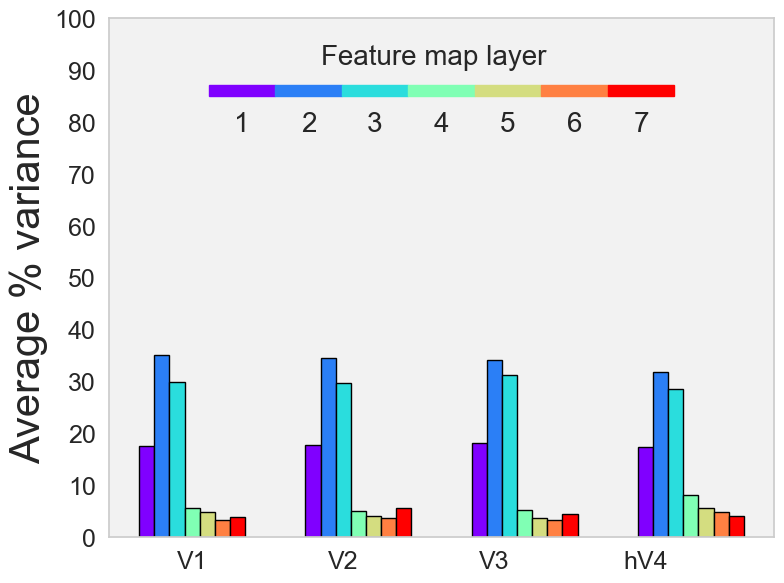

In [68]:
cmap = [plt.get_cmap('rainbow', subject_excl_tunings[s].shape[0])(k) for k in range(7)]

fig,ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    roi_average_y_all=[]
    roi_average_z_all=[]
    for i in range(subject_excl_tunings[s].shape[0]):
        Y, Z, dY, dZ, Ycc = [], [], [], [], []
        for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
            val_cc = subject_total_val_cc[s][:,0] # (mean, std)
            mask = np.logical_and(roi_mask[:len(val_cc)], val_cc>.055)

            Y  += [ subject_excl_tunings[s][i,mask], ] #Y unique
            Z  += [ subject_incl_tunings[s][i,mask], ] #Z specific
            dY  += [ subject_excl_tunings_err[s][i,mask], ]
            dZ  += [ subject_incl_tunings_err[s][i,mask], ]
            Ycc+= [ val_cc[mask], ]

        roi_average_y = [np.average(y, weights=np.square(ycc), axis=0)/n_fmaps[i] for y,ycc in zip(Y, Ycc)]
        roi_average_z = [np.average(z, weights=np.square(ycc), axis=0)/n_fmaps[i] for z,ycc in zip(Z, Ycc)]
        roi_average_dy = [np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)]
        roi_average_dz = [np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)]
        roi_average_y_all.append(roi_average_y)
        roi_average_z_all.append(roi_average_z)
        
    for i in range(subject_excl_tunings[s].shape[0]):
        roi_average_y_sum=np.sum(roi_average_y_all,axis=0)
        roi_average_z_sum=np.sum(roi_average_z_all,axis=0)
        #_=plt.bar(x=1.0*np.arange(len(Y))+0.1*i, height=roi_average_y_all[i]/roi_average_y_sum*100, width=0.1, color=cmap[i], edgecolor='k',alpha=1.0,label=f'layer {i}')
        _=plt.bar(x=1.1*np.arange(len(Y))+0.1*i, height=roi_average_z_all[i]/roi_average_z_sum*100, width=0.1, color=cmap[i], edgecolor='k')
        
        values_y += [roi_average_y,]
        values_z += [roi_average_z,]
        values_dy += [roi_average_dy,]
        values_dz += [roi_average_dz,]    

plt.gca().set_xticks(np.arange(len(roi_group))*1.0+0.3)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance',fontsize=30)
plt.grid(False)
ax.set_yticks(np.arange(0,110,10))

import matplotlib.patches as mpatches
start_x = 0.1
width = 0.1
height = 0.02
y_pos = 0.85  # How far below the plot (adjust as needed)
labels = ['1', '2', '3', '4', '5', '6', '7']
ax.text(1.9,95,'Feature map layer', ha='center', va='top',fontsize=20)
for i, (color, label) in enumerate(zip(cmap, labels)):
    rect = mpatches.Rectangle((start_x + i*width + width/2, y_pos), width, height, color=color, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)
    ax.text(start_x + i*width + width, y_pos - 0.03, label, transform=ax.transAxes, ha='center', va='top', fontsize=20)
    
plt.ylim(0,100)
plt.tight_layout()

In [69]:
filename = output_dir + 'gnet8j_layerwise_specific_z.png'  
fig.savefig(filename, **savearg)
plt.close()

## Reload gnet8r bipartite

In [70]:
data_set = h5py.File(roiwise_model_dir + "gnet8r_bipartite_tuning_var.h5py", 'r')
subject_total_val_cc          = {int(s): np.copy(d) for s,d in embed_dict(data_set)['val_cc'].items()}
subject_partition_incl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['incl_val_cc'].items()}
subject_partition_excl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['excl_val_cc'].items()}
data_set.close()
subject_incl_tunings, subject_incl_tunings_err, subject_incl_tuning_argmax, subject_incl_tuning_spread, \
subject_excl_tunings, subject_excl_tunings_err, subject_excl_tuning_argmax, subject_excl_tuning_spread = \
    tuning_and_spread(subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc)

100%|███████████████████████████████████████████████████████████████████████████| 4657/4657 [00:00<00:00, 41604.19it/s]


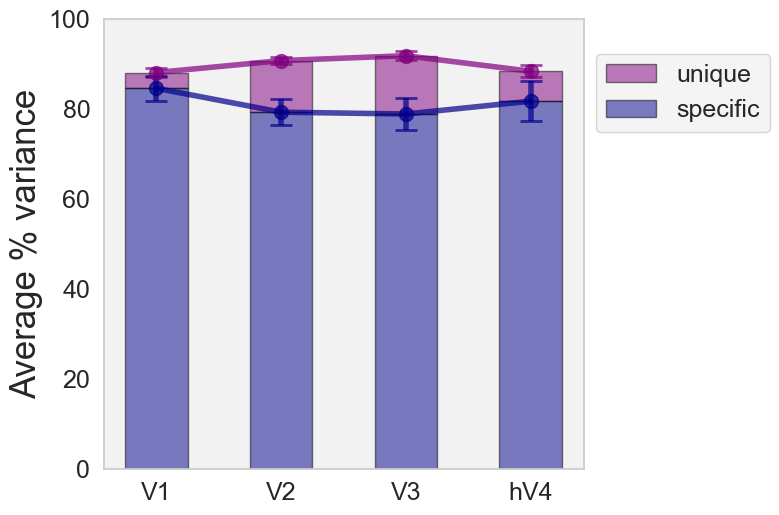

In [72]:
fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    
    Y, Z, dY, dZ, Ycc = [], [], [], [], []
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
        
        val_cc = subject_total_val_cc[s][:,0] # (mean, std)
        mask = np.logical_and(roi_mask[:len(val_cc)], val_cc>.055)
        Y  += [ subject_excl_tunings[s][0,mask], ] #Y unique
        Z  += [ subject_incl_tunings[s][0,mask], ] #Z specific
        dY  += [ subject_excl_tunings_err[s][0,mask], ]
        dZ  += [ subject_incl_tunings_err[s][0,mask], ]
        Ycc+= [ val_cc[mask], ]

    roi_average_z = np.array([np.average(z, weights=np.square(ycc), axis=0) for z,ycc in zip(Z, Ycc)])
    roi_average_y = np.array([np.average(y, weights=np.square(ycc), axis=0) for y,ycc in zip(Y, Ycc)])
    roi_average_dz = np.array([np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)])
    roi_average_dy = np.array([np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)])

    for idx in range(len(Y)):
        if roi_average_y[idx] > roi_average_z[idx]:
            plt.bar(x=idx+1, height=roi_average_y[idx]-roi_average_z[idx], bottom=roi_average_z[idx], width=0.5, color='purple', edgecolor='k', alpha=0.5)
            plt.bar(x=idx+1, height=roi_average_z[idx], width=0.5, color='darkblue', edgecolor='k', alpha=0.5)
        else:
            plt.bar(x=idx+1, height=roi_average_y[idx], width=0.5, color='purple', edgecolor='k', alpha=0.5)
            plt.bar(x=idx+1, height=roi_average_z[idx] - roi_average_y[idx], bottom=roi_average_y[idx], width=0.5, color='darkblue', edgecolor='k', alpha=0.5)
        
    values_y += [roi_average_y,]
    values_z += [roi_average_z,]
    values_dy += [roi_average_dy,]
    values_dz += [roi_average_dz,]    

plt.errorbar(np.arange(len(roi_group))+1, y=np.mean(np.array(values_y), axis=0), yerr=np.sqrt(np.mean(np.array(values_dy)**2, axis=0))/ np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='purple', zorder=99, alpha=0.7)
plt.errorbar(np.arange(len(roi_group))+1, y=np.mean(np.array(values_z), axis=0), yerr=np.sqrt(np.mean(np.array(values_dz)**2, axis=0)) / np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='darkblue', zorder=99, alpha=0.7)

plt.gca().set_xticks(np.arange(len(roi_group))+1)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance',fontsize=25)
plt.ylim(0,100)
plt.grid()
plt.legend(['unique','specific'],bbox_to_anchor=(1., 0.95))

In [73]:
filename = output_dir + 'gnet8r_bipartite.png'  
fig.savefig(filename, **savearg)
plt.close()

## Reload gnet8j bipartite

In [75]:
data_set = h5py.File(joined_model_dir + "gnet8j_bipartite_tuning_var.h5py", 'r')
subject_total_val_cc          = {int(s): np.copy(d) for s,d in embed_dict(data_set)['val_cc'].items()}
subject_partition_incl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['incl_val_cc'].items()}
subject_partition_excl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['excl_val_cc'].items()}
data_set.close()
subject_incl_tunings, subject_incl_tunings_err, subject_incl_tuning_argmax, subject_incl_tuning_spread, \
subject_excl_tunings, subject_excl_tunings_err, subject_excl_tuning_argmax, subject_excl_tuning_spread = \
    tuning_and_spread(subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc)

100%|███████████████████████████████████████████████████████████████████████████| 4657/4657 [00:00<00:00, 35323.38it/s]


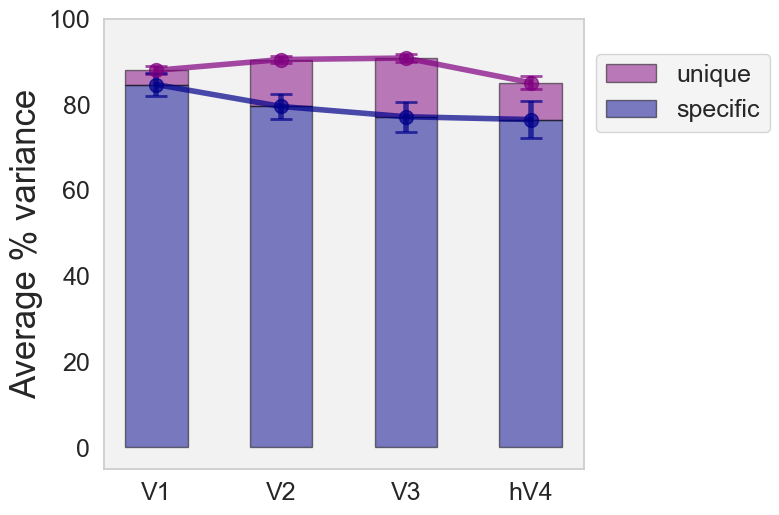

In [76]:
fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    
    Y, Z, dY, dZ, Ycc = [], [], [], [], []
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
        
        val_cc = subject_total_val_cc[s][:,0] # (mean, std)
        mask = np.logical_and(roi_mask[:len(val_cc)], val_cc>.055)
        Y  += [ subject_excl_tunings[s][0,mask], ] #Y unique
        Z  += [ subject_incl_tunings[s][0,mask], ] #Z specific
        dY  += [ subject_excl_tunings_err[s][0,mask], ]
        dZ  += [ subject_incl_tunings_err[s][0,mask], ]
        Ycc+= [ val_cc[mask], ]

    roi_average_z = np.array([np.average(z, weights=np.square(ycc), axis=0) for z,ycc in zip(Z, Ycc)])
    roi_average_y = np.array([np.average(y, weights=np.square(ycc), axis=0) for y,ycc in zip(Y, Ycc)])
    roi_average_dz = np.array([np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)])
    roi_average_dy = np.array([np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)])

    for idx in range(len(Y)):
        if roi_average_y[idx] > roi_average_z[idx]:
            plt.bar(x=idx+1, height=roi_average_y[idx]-roi_average_z[idx], bottom=roi_average_z[idx], width=0.5, color='purple', edgecolor='k', alpha=0.5)
            plt.bar(x=idx+1, height=roi_average_z[idx], width=0.5, color='darkblue', edgecolor='k', alpha=0.5)
        else:
            plt.bar(x=idx+1, height=roi_average_y[idx], width=0.5, color='purple', edgecolor='k', alpha=0.5)
            plt.bar(x=idx+1, height=roi_average_z[idx] - roi_average_y[idx], bottom=roi_average_y[idx], width=0.5, color='darkblue', edgecolor='k', alpha=0.5)
        
    values_y += [roi_average_y,]
    values_z += [roi_average_z,]
    values_dy += [roi_average_dy,]
    values_dz += [roi_average_dz,]    

plt.errorbar(np.arange(len(roi_group))+1, y=np.mean(np.array(values_y), axis=0), yerr=np.sqrt(np.mean(np.array(values_dy)**2, axis=0))/ np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='purple', zorder=99, alpha=0.7)
plt.errorbar(np.arange(len(roi_group))+1, y=np.mean(np.array(values_z), axis=0), yerr=np.sqrt(np.mean(np.array(values_dz)**2, axis=0)) / np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='darkblue', zorder=99, alpha=0.7)

plt.gca().set_xticks(np.arange(len(roi_group))+1)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance',fontsize=25)
plt.ylim(-5,100)
plt.grid()
plt.legend(['unique','specific'],bbox_to_anchor=(1., 0.95))
print()

In [77]:
filename = output_dir + 'gnet8j_bipartite.png'  
fig.savefig(filename, **savearg)
plt.close()